<a href="https://colab.research.google.com/github/Karima-mtq/Basemap/blob/main/TP_ACP_SST_hadley_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


texte en italique## 1. Load basic libraries

In [3]:
!pip install netCDF4
!pip install eofs
!pip install Basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 38.6 MB/s eta 0:00:00


In [2]:
%matplotlib inline
from scipy import signal
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof
from netCDF4 import num2date
import numpy as np
import numpy.polynomial.polynomial as poly
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

## 2. Load SST and mask data

# 2.1 Read SST

In [3]:
infile = '/content/drive/MyDrive/phd/data/HadISST_sst.nc'
ncin = Dataset(infile, 'r')
print(ncin)
################global##############################################
sst  = ncin.variables['sst'][1320:-157,:,:] #1980 to 2000
lat  = ncin.variables['latitude'][:]
lon  = ncin.variables['longitude'][:]
################ATLANTIC##############################################
#sst  = ncin.variables['sst'][1320:-277,:-80,100:-170] #1980 to 2010
#lat  = ncin.variables['latitude'][:-80]
#lon  = ncin.variables['longitude'][100:-170]
################Pacific##############################################
#sst  = ncin.variables['sst'][1320:-277,60:-60,-60:] #1980 to 2000
#lat  = ncin.variables['latitude'][60:-60]
#lon  = ncin.variables['longitude'][-60:]
#sst = ncin.variables['sst'][1320:-277,60:-60,:120]
#lon  = ncin.variables['longitude'][:120]
#sst = np.concatenate((sst2, sst1), axis=-1)
# Combine lon2 and lon1 into a single array
#lon = np.concatenate((lon2, lon1))
######################################
time_values = ncin.variables['time'][1320:-157]
units = ncin.variables['time'].units
# Convert numeric time values to dates
dates = num2date(time_values, units=units)
mask = sst.mask
# Replace -1.e+30f with NaN
sst_data = sst[:]
sst_data[sst_data == -1.e+30] = np.nan
sst_data[sst_data == -1.e+3] = np.nan
sst[:] = sst_data
ncin.close()
nt,nlat,nlon = sst.shape
year1=dates[0].year
year2=dates[-1].year
print(sst.shape)
print(dates[0],dates[-1], nt)
startY = year1
endY   = year2
ndy    = year2-year1+1
ny = nt/ndy
print(startY, endY, ndy, ny)

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Title: Monthly version of HadISST sea surface temperature component
    description: HadISST 1.1 monthly average sea surface temperature
    institution: Met Office Hadley Centre
    source: HadISST
    reference: Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., Kent, E. C., Kaplan, A.  Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century J. Geophys. Res.Vol. 108, No. D14, 4407 10.1029/2002JD002670
    Conventions: CF-1.0
    history: 5/3/2024 converted to netcdf from pp format
    supplementary_information: Updates and supplementary information will be available from http://www.metoffice.gov.uk/hadobs/hadisst
    comment: Data restrictions: for academic research use only. Data are Crown copyright see (http://www.opsi.gov.uk/advice/crown-copyright/copyright-guidance/index.htm)
    dime

## 2.3. Detrend and remove seasonal cycle

# 2.3.1 Rearrange data for seasonal removal

In [4]:
sst_detrend = np.empty(sst.shape)
sst_coeffs  = np.empty((2, nlat, nlon))
sst_detrend[:,:,:] = np.nan
x = np.linspace(1,nt,nt)
for i in range(0, nlat):
  for j in range(0,nlon):
    ytemp = np.copy(sst[:,i,j])
    y = sst[:,i,j]
    b = ~np.isnan(y)
    coefs = poly.polyfit(x[b], y[b], 1)
    sst_coeffs[0,i,j] = coefs[0]
    sst_coeffs[1,i,j] = coefs[1]
    ffit = poly.polyval(x[b], coefs)
    sst_detrend[b,i,j] = y[b] - ffit

In [5]:

sst_all = sst_detrend.reshape((ndy,int(ny),nlat,nlon), order='F').transpose((1,0,2,3)) # year, 36, lat, lon
sst_season = np.mean(sst_all, axis=0)
sst_diff = sst_all - sst_season
sst_diff = np.ma.masked_array(sst_diff, mask=mask) # have to do this, or fill in zeros in sst_diff.
sst_final = sst_diff.transpose((1,0,2,3)).reshape((ndy*int(ny),nlat,nlon), order='F')



## 4. Carry out EOF analysis

### 4.1 Create an EOF solver to do the EOF analysis

Cosine of latitude weights are applied before the computation of EOFs.

In [6]:
coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_final, weights=wgts)

print(coslat.shape)
print(wgts.shape)

(180,)
(180, 1)


In [7]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

### 4.3 Retrieve the leading EOFs



## 5. Visualize leading EOFs

### 5.1 Plot EOFs and PCs

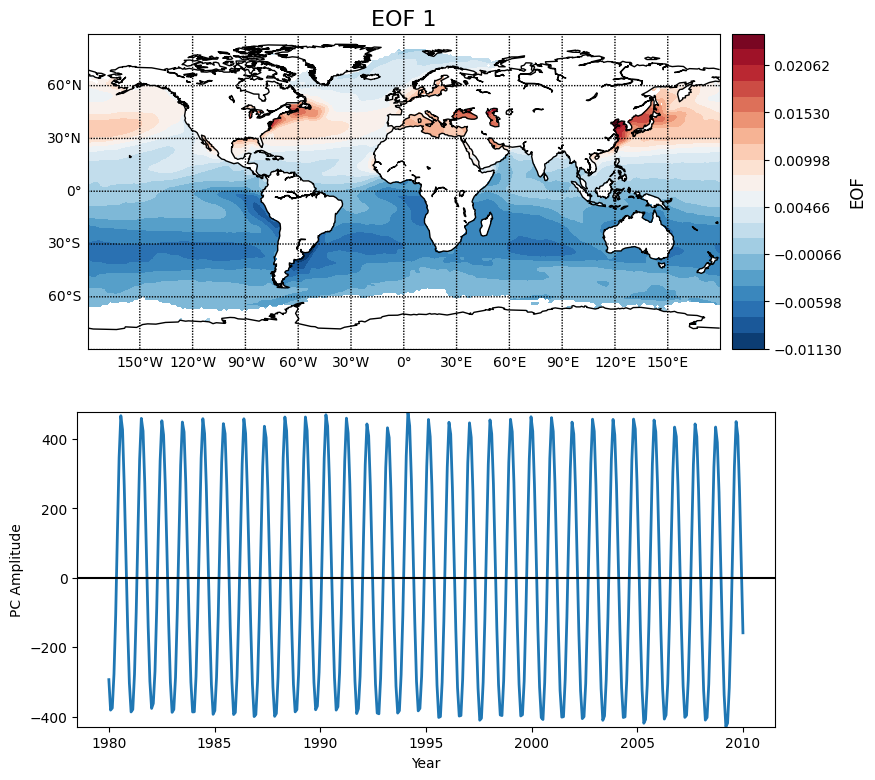

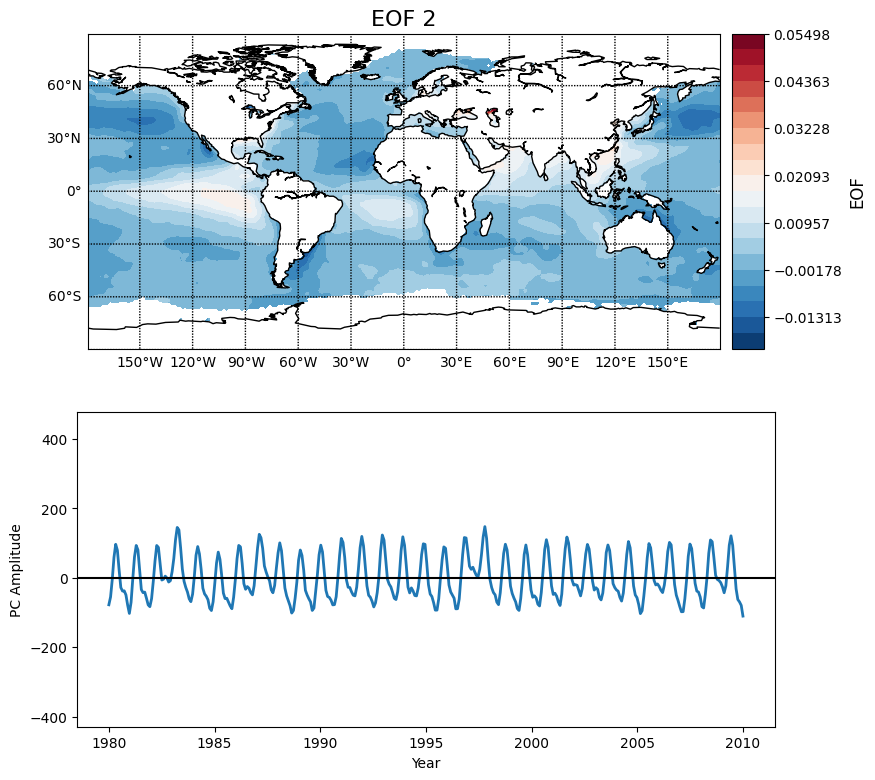

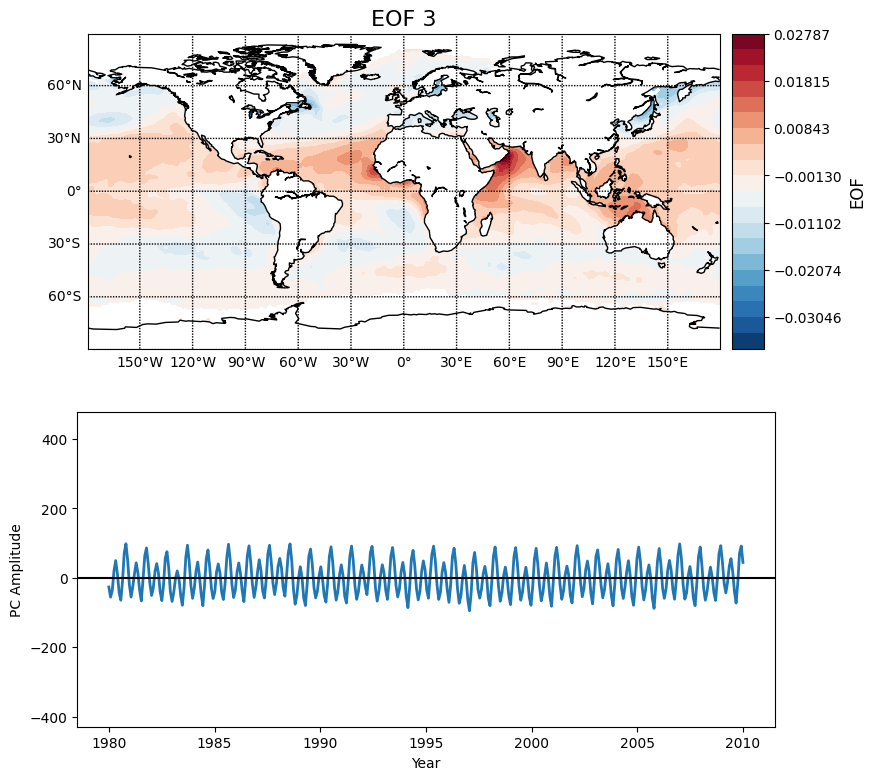

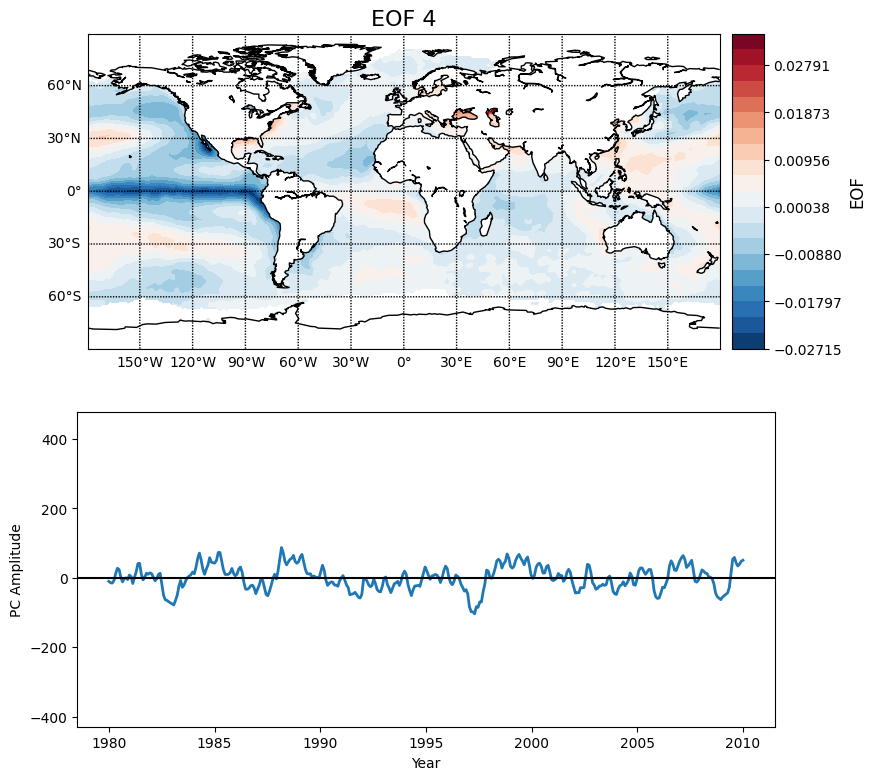

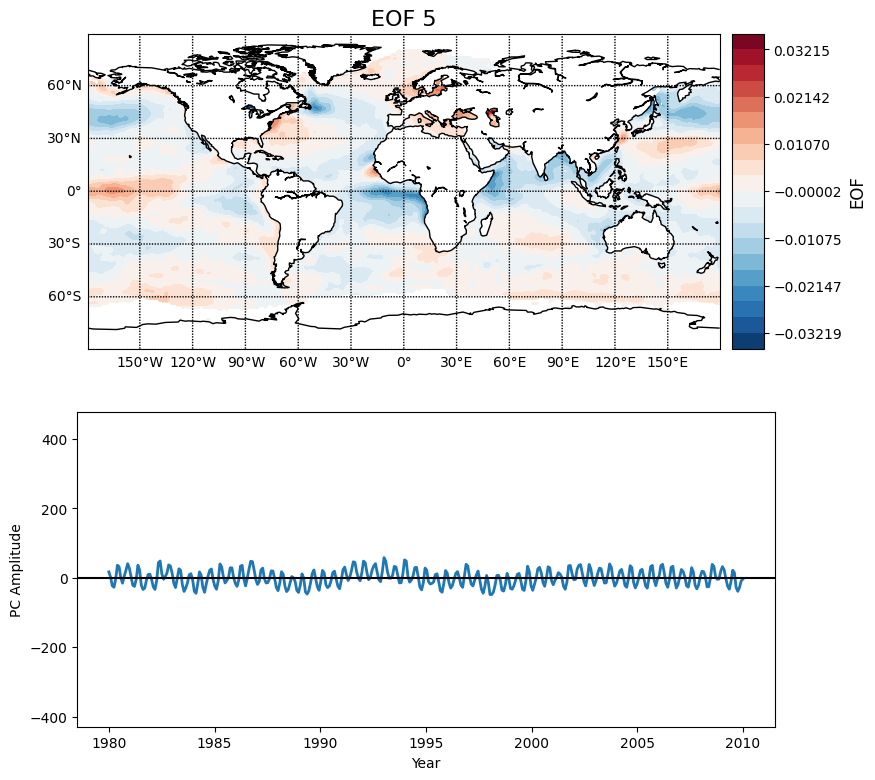

In [8]:
parallels = np.arange(-90,90,30.)
meridians = np.arange(-180,180,30)

for i in range(0,5):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)

    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat), urcrnrlon=max(lon), urcrnrlat=max(lat))
    x, y = m(*np.meshgrid(lon, lat))
    clevs = np.linspace(np.min(eof1[i,:,:].squeeze()), np.max(eof1[i,:,:].squeeze()), 21)
    cs = m.contourf(x, y, eof1[i,:,:].squeeze(), clevs, cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])

    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    #days = np.linspace(year1,year2,int(nt))
    days = np.linspace(year1, year2, int(nt))
    plt.plot(days, pc1[:,i], linewidth=2)
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))

    #plt.savefig('EOF' + str(i+1)+'.png')
    #plt.savefig('EOF' + str(i+1)+'.pdf')

### 5.2 Check variances explained by leading EOFs

(2.6972289760749988e-33, 0.8826984495004259)

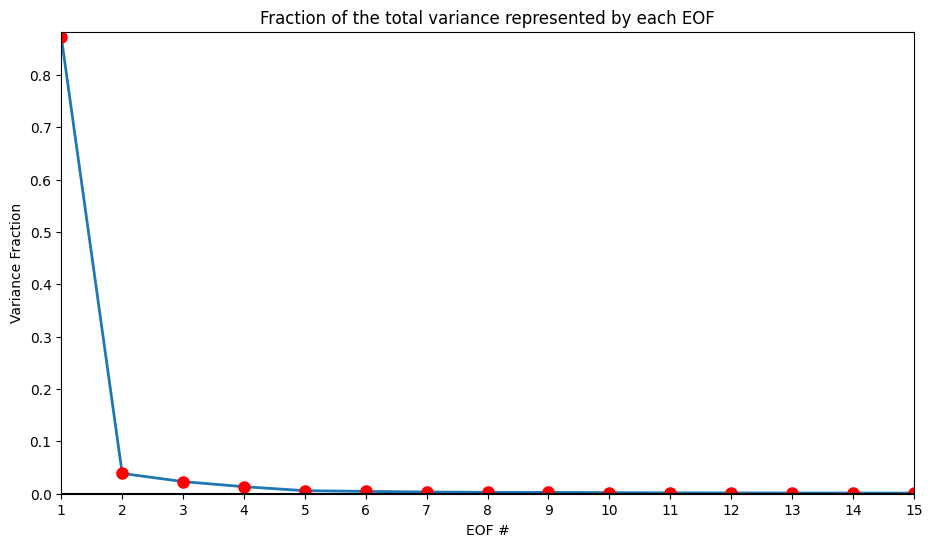

In [ ]:
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
#plt.savefig('ScreePlot-Explained-Variance.png')
#plt.savefig('ScreePlot-Explained-Variance.pdf')

In [ ]:
sum = 0
for i in range(0, 5):
    sum = sum + round(varfrac[i]*100)
    print("EOF", i, "explain", round(varfrac[i]*100), "%",", variance Cumulée :", sum, "%")

EOF 0 explain 87 % , variance Cumulée : 87 %
EOF 1 explain 4 % , variance Cumulée : 91 %
EOF 2 explain 2 % , variance Cumulée : 93 %
EOF 3 explain 1 % , variance Cumulée : 94 %
EOF 4 explain 1 % , variance Cumulée : 95 %
